# The 2-Qubit Design, Version 2

### Changes with this design
#### - Resonator frequencies starts from 6.8 and go as following 7.2, 7.6 and 8.0 GHz
#### - Launch pads and all the resonator etc set to 45 Ohm (check new gap values!)

### 1. The Maxwell Capacitance Matrix
#### 1a.Calculations of Q_c and Kappa

### 2. EPR simulations-will be added

### 3. Creating the GDS file

### Preparations

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict
import matplotlib.pyplot as plt

from qiskit_metal.toolbox_metal import math_and_overrides

from qiskit_metal.qlibrary.core import QComponent

from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors

from qiskit_metal.qlibrary.qubits.fluxonium_v2 import FluxoniumPocket
from qiskit_metal.qlibrary.qubits.fluxonium_withJJ import FluxoniumPocket

from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond

from qiskit_metal.qlibrary.terminations.open_to_ground_v2 import OpenToGround
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer

from qiskit_metal.analyses.sweep_and_optimize.sweeping import Sweeping

import pyEPR as epr
from qiskit_metal.analyses.quantization import EPRanalysis 

In [2]:
# Each time you create a new quantum circuit design,
# you start by instantiating a QDesign class.

# The design class `DesignPlanar` is best for 2D circuit designs.
design = designs.DesignPlanar()
design.chips.main.material = 'silicon'  # our substrate is Silicon
# cpw_width and cpw_gap is defined from the beginnning if you need you can 
# change it later. But with this way one can be sure all the lines are having same width and gap.
design.variables['cpw_width'] = '15 um'  
design.variables['cpw_gap'] = '5.909 um' # was 8.733um
design._chips['main']['size']['size_x'] = '9mm'  # Our device size is 9*9mm
design._chips['main']['size']['size_y'] = '9mm'
design._chips['main']['size']['size_z'] = '-525um' #Our wafer thicknes is 525 um+/-10

# If you disable the next line with "overwrite_enabled", then you will need to
# delete a component [<component>.delete()] before recreating it.
design.overwrite_enabled = True

eig_qres = EPRanalysis(design, "hfss")
hfss = design.renderers.hfss
hfss = eig_qres.sim.renderer
q3d = design.renderers.q3d

# run the GUI 
gui = MetalGUI(design)

In [3]:
from qiskit_metal.qlibrary.terminations.ebeam_marker_v2 import Markers
from qiskit_metal.qlibrary.terminations.ebeam_frame import Frame
## Markers for ebeam
options = dict(pos_x='3.25mm', pos_y='4.25mm')
mrk1 = Markers(design, 'marker1', options = options)
options = dict(pos_x='-3.25mm', pos_y='4.25mm')
mrk2 = Markers(design, 'marker2', options = options)
options = dict(pos_x='-3.25mm', pos_y='-4.25mm')
mrk3 = Markers(design, 'marker3', options = options)
options = dict(pos_x='3.25mm', pos_y='-4.25mm')
mrk4 = Markers(design, 'marker4', options = options)
options = dict(chip='main', f_gap='140um',)
frame = Frame(design, 'frame', options = options)
gui.rebuild()

In [11]:
#Setup the launchpad1 location and orientation

## Read In launch pad
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='-3.99mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um',
                    )
lp = LaunchpadWirebond(design, 'LPReadIn', options = launch_options)


# Read Out launch pad
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='3.99mm', orientation='180',
                      lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um',
                    )
lp = LaunchpadWirebond(design, 'LPReadOut', options = launch_options)


Transmission_Line = {'pin_inputs':
           {'start_pin': {'component': 'LPReadIn', 'pin': 'tie'},
             'end_pin': {'component': 'LPReadOut', 'pin': 'tie'}},
            'lead': {'start_straight': '3970um', 'end_straight': '3970um',
                    # 'start_jogged_extension': jogs_in,
                    # 'anchors': anchors1,
                    }, 
                    'total_length': '8mm', 'fillet': "90um"
            }

TransLine = RoutePathfinder(design, 'TL', Transmission_Line)


gui.rebuild()

In [4]:
from qiskit_metal.qlibrary.qubits.fluxonium_withJJ import FluxoniumPocket

gds_cell_name_jj = 'junction_0'

## Every qubit options are slightly different than each other, that's why I seperated them. 
# Q1 details
gds_cell_name_inductor = 'jj_array_v2_0'
options = dict(chip='main', nanowire = False,
            gds_cell_name=gds_cell_name_jj,
            gds_cell_inductor=gds_cell_name_inductor ,
               inductor_orientation='-1', jj_orientation='1',
                    
    flux_bias_line_options=Dict(make_fbl = True, cpw_gap = '8.409um'),
    charge_line_options=Dict(loc_H = -1, make_cl = True), 
    readout_line_options=Dict(loc_H = +1, make_rol = True)
              )

q1 = FluxoniumPocket(design,'Q1', options = dict(pos_x = '-2.2mm', pos_y = '-0.485mm',orientation =270,
        **options))

# Q2 details
gds_cell_name_inductor = 'jj_array_v1_0'
options = dict(chip='main', nanowire = False, 
            gds_cell_name=gds_cell_name_jj,
            gds_cell_inductor=gds_cell_name_inductor , 
               inductor_orientation='-1', 
               
    flux_bias_line_options=Dict(make_fbl = True, cpw_gap = '8.409um' # was '11.233um'
                               ),
    charge_line_options=Dict(loc_H = +1, make_cl = True),
    readout_line_options=Dict(loc_H = -1, make_rol = True) 
              )

q2 = FluxoniumPocket(design,'Q2', options = dict(pos_x = '-2.2mm', pos_y = '0.485mm',orientation =90,
             **options))

# Q4 details
gds_cell_name_inductor = 'jj_array_v1_0'
options = dict(chip='main', nanowire = False,               
            gds_cell_name=gds_cell_name_jj,
            gds_cell_inductor=gds_cell_name_inductor,
               inductor_orientation='-1', 
                    
    flux_bias_line_options=Dict(make_fbl = True, cpw_gap = '8.409um'),
    charge_line_options=Dict(loc_H = -1, make_cl = True), 
    readout_line_options=Dict(loc_H = +1, make_rol = True) 
              )

q4 = FluxoniumPocket(design,'Q4', options = dict(pos_x = '2.2mm', pos_y = '0.485mm',orientation =90,
        **options))

               
# Q5 details    
gds_cell_name_inductor = 'jj_array_v2_0'
options = dict(chip='main', nanowire = False, 
            gds_cell_name=gds_cell_name_jj,
            gds_cell_inductor=gds_cell_name_inductor,
               inductor_orientation='-1', jj_orientation='1',
                           
    flux_bias_line_options=Dict(make_fbl = True, cpw_gap = '8.409um'), 
    charge_line_options=Dict(loc_H = +1, make_cl = True),
    readout_line_options=Dict(loc_H = -1, make_rol = True) 
              )

q5 = FluxoniumPocket(design,'Q5', options = dict(pos_x = '2.2mm', pos_y = '-0.485mm',orientation =270,
             **options))

gui.rebuild()
gui.autoscale()

In [6]:
from qiskit_metal.qlibrary.qubits.tmon_c import Tmon_c
gds_cell_name_jj = 'junction_sq_1'

# Qc-3 details
options = dict(jj_gap ='30um', pad_arm_length='810um', pad_head_length='400um',
        pad_arm_width='25um', palm_radius='63um',
       pad_gap='30um', circle_gap='8um', x_gap='38.5um',
                     gds_cell_name=gds_cell_name_jj,      
    flux_bias_line_options=Dict(make_fbl = True, fbl_sep='30um', 
                            fbl_length = '100um'), 
                                 )
               
# Create a new Transmon Cross object with name 'Q3'
q3 = Tmon_c(design, 'Q3', options=dict(pos_x = '-2.36mm', pos_y = '0mm', 
                                       orientation='90',
                                             **options))
# Qc-6 details
gds_cell_name_jj = 'junction_sq_0'
options = dict(jj_gap ='30um', pad_arm_length='810um', pad_head_length='400um',
        pad_arm_width='25um', palm_radius='63um',
       pad_gap='30um', circle_gap='8um', x_gap='38.5um',
                     gds_cell_name=gds_cell_name_jj,       
    flux_bias_line_options=Dict(make_fbl = True, fbl_sep='30um', 
                            fbl_length = '100um'), 
                                 )
q6 = Tmon_c(design, 'Q6', options=dict(pos_x = '2.36mm', pos_y = '0mm', 
                                       orientation='270',
                                             **options))

gui.rebuild()  # rebuild the design and plot
#gui.autoscale() #resize GUI to see QComponent

In [7]:
## The test structures: these are for room temp probing!
# Q JJ1 Trial details
gds_cell_name_jj = 'junction_0'
gds_cell_name_inductor = 'jj_array_v1_0'
options = dict(chip='main',  nanowire = False,
        orientation =90, pos_x = '-1.0mm', pos_y = '3.0mm',
               pocket_width= '600um',
        gds_cell_name=gds_cell_name_jj,
    flux_bias_line_options=Dict(make_fbl = False),
    charge_line_options=Dict(loc_H = -1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = 1, make_rol = False,
              ) )
qJJ1 = FluxoniumPocket(design,'QJJ1', options = dict(
        **options))
# Q JJ2 Trial details
options = dict(chip='main', nanowire = False,
        orientation =90, pos_x = '-1.0mm', pos_y = '3.2mm',
               pocket_width= '600um',
        gds_cell_name=gds_cell_name_jj,
    flux_bias_line_options=Dict(make_fbl = False),
    charge_line_options=Dict(loc_H = -1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = 1, make_rol = False,
              ) )
qJJ2 = FluxoniumPocket(design,'QJJ2', options = dict(
        **options))
# Q JJ3 Trial details
options = dict(chip='main', nanowire = False,
        orientation =90, pos_x = '-1.0mm', pos_y = '3.4mm',
               pocket_width= '600um',
        gds_cell_name=gds_cell_name_jj,
    flux_bias_line_options=Dict(make_fbl = False),
    charge_line_options=Dict(loc_H = -1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = 1, make_rol = False,
              ) )
qJJ3 = FluxoniumPocket(design,'QJJ3', options = dict(
        **options))
# Q Array1 details
options = dict(chip='main', nanowire = False,
            orientation =90, pos_x = '1.0mm', pos_y = '3.0mm',
            gds_cell_inductor=gds_cell_name_inductor , pocket_width= '600um',
               inductor_orientation='-1',
    flux_bias_line_options=Dict(make_fbl = False,
                        ),
    charge_line_options=Dict(loc_H = +1, make_cl = False,
               ),
    readout_line_options=Dict(loc_H = -1, make_rol = False,
              ) )
qArr1 = FluxoniumPocket(design,'QArr1', options = dict(
             **options))
# Q Array2 Trial details
options = dict(chip='main', nanowire = False,
        orientation =90, pos_x = '1.0mm', pos_y = '3.2mm',
               pocket_width= '600um',
        gds_cell_inductor=gds_cell_name_inductor ,
               inductor_orientation='-1',
    flux_bias_line_options=Dict(make_fbl = False,
                               ),
    charge_line_options=Dict(loc_H = +1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = -1, make_rol = False,
              ) )
qArr2 = FluxoniumPocket(design,'QArr2', options = dict(
        **options))
# Q Array3 Trial details
options = dict(chip='main', nanowire = False,
        orientation =90, pos_x = '1.0mm', pos_y = '3.4mm',
               pocket_width= '600um',
        gds_cell_inductor=gds_cell_name_inductor ,
               inductor_orientation='-1',
    flux_bias_line_options=Dict(make_fbl = False,
                      ),
    charge_line_options=Dict(loc_H = +1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = -1, make_rol = False,
              ) )
qArr3 = FluxoniumPocket(design,'QArr3', options = dict(
        **options))
gui.rebuild()

In [8]:
# Lambda/2 resonators - Resonator1
from collections import OrderedDict
jogs_in = OrderedDict()
jogs_in[0] = ["R", '200um']
jogs_in[1] = ["R", '200um']

otg1 = OpenToGround(design, 'otg1s', options=dict(chip='main', 
                 pos_x='-32.0um', pos_y='-0.25mm', orientation='90'))
rt_meander = RouteMeander(design, 'cavity1',  Dict(meander=Dict(spacing='200um'),
        total_length='8.69mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='1450um', 
                    start_jogged_extension= jogs_in),
        pin_inputs=Dict(
            start_pin=Dict(component='otg1s', pin='open'),
            end_pin=Dict(component='Q1', pin='readout_line')), ))

# Lambda/2 resonators - Resonator2
jogs_in = OrderedDict()
jogs_in[0] = ["L", '200um']
jogs_in[1] = ["L", '200um']

otg2 = OpenToGround(design, 'otg2s', options=dict(chip='main', 
                 pos_x='-32.0um', pos_y='0.6mm', orientation='270'))
rt_meander = RouteMeander(design, 'cavity2',  Dict(meander=Dict(spacing='200um'),
        total_length='8.195mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='1350um', 
                    start_jogged_extension= jogs_in),
        pin_inputs=Dict(
            start_pin=Dict(component='otg2s', pin='open'),
            end_pin=Dict(component='Q2', pin='readout_line')), ))

# Lambda/2 resonators - Resonator4

jogs_in = OrderedDict()
jogs_in[0] = ["R", '200um']
jogs_in[1] = ["R", '200um']

otg4 = OpenToGround(design, 'otg4s', options=dict(chip='main', 
                    pos_x='32.0um',  pos_y='0.5mm', orientation='270'))
rt_meander = RouteMeander(design, 'cavity4',  Dict(meander=Dict(spacing='200um'),
        total_length='7.78mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='1250um', 
                    start_jogged_extension= jogs_in),
        pin_inputs=Dict(
            start_pin=Dict(component='otg4s', pin='open'),
            end_pin=Dict(component='Q4', pin='readout_line')), ))

# Lambda/2 resonators - Resonator5
jogs_in = OrderedDict()
jogs_in[0] = ["L", '200um']
jogs_in[1] = ["L", '200um']

otg5= OpenToGround(design, 'otg5s', options=dict(chip='main', 
                 pos_x='32.0um', pos_y='-0.5mm', orientation='90'))
rt_meander = RouteMeander(design, 'cavity5',  Dict(meander=Dict(spacing='200um'),
        total_length='7.38mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='1190um', 
                    start_jogged_extension= jogs_in),
        pin_inputs=Dict(
            start_pin=Dict(component='otg5s', pin='open'),
            end_pin=Dict(component='Q5', pin='readout_line')), ))

gui.rebuild()

In [9]:
# Q1 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='-1.34mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPCL1', options = launch_options) #change line
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='-2.68mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPFB1', options = launch_options) #flux line
# Q2 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='1.34mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPCL2', options = launch_options) #charge line
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='2.68mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPFB2', options = launch_options) #flux line
# Q4 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='1.348mm', orientation='180',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPCL4', options = launch_options) #change line
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='2.68mm', orientation='180',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPFB4', options = launch_options) #flux line
# Q5 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='-1.34mm', orientation='180',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPCL5', options = launch_options) #change line
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='-2.68mm', orientation='180',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPFB5', options = launch_options) #flux line
# Q3 flux-bias line's lauch pad, the tmon
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='0.0575mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPFB3', options = launch_options) #flux line
# Q6 flux-bias line's lauch pad, the tmon
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='-0.0575mm', orientation='180',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='76.5um')
lp = LaunchpadWirebond(design, 'LPFB6', options = launch_options) #flux line
gui.rebuild()

In [10]:
#Charge Line for Q1
XYCharge_LineQ1 = RoutePathfinder(design, 'XY_Gate1',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='150um', end_straight='850um',
                      ),
                         pin_inputs=Dict( start_pin=Dict(
                                          component='Q1',
                                               pin='charge_line'),
                                                end_pin=Dict(
                                            component='LPCL1',
                                            pin='tie')
                                            )))
# Flux Bias Line for Q1
ZFluxBias_LineQ1 = RoutePathfinder(design, 'Z_Gate1',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='200um',
        end_straight='400um', ),
        pin_inputs=Dict(start_pin=Dict(component='Q1',
              pin='flux_bias_line'),
          end_pin=Dict(component='LPFB1', pin='tie')
                                   )))
# Charge Lıne for Q2
XYCharge_LineQ2 = RoutePathfinder(design, 'XY_Gate2', options = dict(chip='main',
                        fillet='80um',
                lead=dict(start_straight='150um', end_straight='850um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q2',
                                                    pin='charge_line'),
                                                end_pin=Dict(
                                                    component='LPCL2',
                                                    pin='tie')
                                            )))
# Flux Bias Line for Q2
ZFluxBias_LineQ2 = RoutePathfinder(design, 'Z_Gate2', options = dict(chip='main',
             fillet='99um',
          lead=dict(start_straight='250um', end_straight='250um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q2',
                                                    pin='flux_bias_line'),
                                                end_pin=Dict(
                                                    component='LPFB2',
                                                    pin='tie')
                                            )))
#Charge Line for Q4
XYCharge_LineQ4 = RoutePathfinder(design, 'XY_Gate4',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='150um', end_straight='600um'),
                         pin_inputs=Dict( start_pin=Dict(
                                          component='Q4',
                                               pin='charge_line'),
                                                end_pin=Dict(
                                            component='LPCL4',
                                            pin='tie')
                                            )))
# Flux Bias Line for Q4
ZFluxBias_LineQ4 = RoutePathfinder(design, 'Z_Gate4',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='200um',
        end_straight='400um', ),
        pin_inputs=Dict(start_pin=Dict(component='Q4',
              pin='flux_bias_line'),
          end_pin=Dict(component='LPFB4', pin='tie')
                                   )))
#Charge Line for Q5
XYCharge_LineQ5 = RoutePathfinder(design, 'XY_Gate5',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='150um', end_straight='600um',
                      ),
                         pin_inputs=Dict( start_pin=Dict(
                                          component='Q5',
                                               pin='charge_line'),
                                                end_pin=Dict(
                                            component='LPCL5',
                                            pin='tie')
                                            )))
# Flux Bias Line for Q5
ZFluxBias_LineQ5 = RoutePathfinder(design, 'Z_Gate5',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='200um',
        end_straight='400um', ),
        pin_inputs=Dict(start_pin=Dict(component='Q5',
              pin='flux_bias_line'),
          end_pin=Dict(component='LPFB5', pin='tie')
                                   )))
# Flux Bias Line for Q3
ZFluxBias_LineQ3 = RoutePathfinder(design, 'Z_Gate3', options = dict(chip='main',
             fillet='20um',
          lead=dict(start_straight='150um', end_straight='80um'),
        pin_inputs=Dict(start_pin=Dict(component='Q3',
                 pin='flux_bias_line'),
                end_pin=Dict(component='LPFB3',pin='tie')
                                            )))
# Flux Bias Line for Q6
ZFluxBias_LineQ6 = RoutePathfinder(design, 'Z_Gate6', options = dict(chip='main',
             fillet='99um',
          lead=dict(start_straight='250um', end_straight='250um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q6',
                                                    pin='flux_bias_line'),
                                                end_pin=Dict(
                                                    component='LPFB6',
                                                    pin='tie')
                                            )))
gui.rebuild()

In [5]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")
c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

In [6]:
# for second method. dont run this
# example: update single setting
c1.sim.setup.max_passes = 20
# example: update multiple settings
c1.sim.setup_update(solution_order = 'Medium', auto_increase_solution_order = 'False')

c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 20,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': 'False',
 'solution_order': 'Medium',
 'solver_type': 'Iterative'}

In [7]:
# Qubit 5 has the default settings in terms of readout pads and charge line places.
c1.sim.run(components=['Q1', 'Q2', 'Q3'], open_terminations=
           [('Q1', 'charge_line'), ('Q1', 'flux_bias_line'), ('Q1', 'fake_flux_bias_line'),('Q1', 'readout_line'),
            ('Q2', 'charge_line'), ('Q2', 'flux_bias_line'), ('Q2', 'fake_flux_bias_line'),('Q2', 'readout_line'),
            ('Q3', 'flux_bias_line'), ('Q3', 'fake_flux_bias_line')])
c1.sim.capacitance_matrix

INFO 05:14PM [connect_project]: Connecting to Ansys Desktop API...
INFO 05:14PM [load_ansys_project]: 	Opened Ansys App
INFO 05:14PM [load_ansys_project]: 	Opened Ansys Desktop v2021.2.0
INFO 05:14PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/ana/
	Project:   Project81
INFO 05:14PM [connect_design]: No active design found (or error getting active design).
INFO 05:14PM [connect]: 	 Connected to project "Project81". No design detected
INFO 05:14PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
WARNING 05:14PM [connect_setup]: 	No design setup detected.
WARNING 05:14PM [connect_setup]: 	Creating Q3D default setup.
INFO 05:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:14PM [analyze]: Analyzing setup Setup
INFO 05:15PM [get_matrix]: Exporting matrix data to (C:\Users\siywa\AppData\Local\Temp\tmp4l2q0zfi.txt, C, ,

,charge_line_Q1,charge_line_Q2,flux_bias_line_Q1,flux_bias_line_Q2,flux_bias_line_Q3,ground_main_plane,pad_bot_Q1,pad_bot_Q2,pad_top_Q1,pad_top_Q2,readout_padNline_Q1,readout_padNline_Q2,tmon_Q3
charge_line_Q1,22.06853,-0.00061,-0.12703,-0.00438,-0.00375,-21.01718,-0.53288,-0.00564,-0.05220,-0.00529,-0.03599,-0.00859,-0.19876
charge_line_Q2,-0.00061,22.06858,-0.00435,-0.12671,-0.00416,-21.01598,-0.00528,-0.05223,-0.00562,-0.53271,-0.00858,-0.03604,-0.19881
flux_bias_line_Q1,-0.12703,-0.00435,59.38361,-0.07666,-0.02342,-45.04294,-4.42463,-0.07468,-4.66449,-0.06308,-2.11121,-0.14149,-1.32191
flux_bias_line_Q2,-0.00438,-0.12671,-0.07666,59.33997,-0.02421,-44.95983,-0.06309,-4.66333,-0.07464,-4.41669,-0.14160,-2.11294,-1.32134
flux_bias_line_Q3,-0.00375,-0.00416,-0.02342,-0.02421,62.92976,-62.17783,-0.02418,-0.01845,-0.01767,-0.02616,-0.02220,-0.02212,-0.50716
ground_main_plane,-21.01718,-21.01598,-45.04294,-44.95983,-62.17783,816.01268,-21.09146,-20.79569,-20.79648,-21.08942,-165.60509,-165.57906,-108.43629
pad_bot_Q1,-0.53288,-0.00528,-4.42463,-0.06309,-0.02418,-21.09146,40.79281,-0.07250,-3.06499,-0.05826,-0.81467,-0.11747,-9.86928
pad_bot_Q2,-0.00564,-0.05223,-0.07468,-4.66333,-0.01845,-20.79569,-0.07250,37.10060,-0.10005,-3.06598,-0.17468,-5.39740,-1.84433
pad_top_Q1,-0.05220,-0.00562,-4.66449,-0.07464,-0.01767,-20.79648,-3.06499,-0.10005,37.10391,-0.07248,-5.39848,-0.17440,-1.84199
pad_top_Q2,-0.00529,-0.53271,-0.06308,-4.41669,-0.02616,-21.08942,-0.05826,-3.06598,-0.07248,40.78766,-0.11751,-0.81507,-9.87204


In [44]:
# Here, the calculation of g (coupling strength between FX1 to FX2)
import numpy as np
e = 1.60217663e-19
hbar = 1.05457182e-34

C1t_c = Cc_1t = Cc_2t = C2t_c = 9.80*10**(-15) ## qubit 1 top pad to coupler
C1b_c = Cc_1b = Cc_2b = C2b_c = 1.83*10**(-15) ## qubit 1 bottom pad to coupler
C1b_gnd = C2b                 = 20.79*10**(-15) ## qubit 1 bottom pad to ground
C1t_gnd = C2t                 = 20.78*10**(-15)  ## qubit 1 top pad to ground
Cc                            = 108.03*10**(-15) ## coupler qubit to ground
C1t_1b= C1b_1t = C2t_2b = C2b_2t = 3.05*10**(-15) 


C11 = C1t_gnd + C1t_1b + C1t_c
C22 = C1b_gnd + C1b_1t + C1b_c
C33 = Cc + Cc_1t + Cc_1b + Cc_2t + Cc_2b
C44 = C2t + C2t_2b + C2t_c
C55 = C2b + C2b_2t + C2b_c

Csigma = C11*C22*C33*C44*C55



g1_2_n=(2*e)**2*((Cc_2t*C55- Cc_2b*C44)*(C1t_1b*(C1b_c-C1t_c)-C11*C1b_c+C1t_c*C22)+C2t_2b*(Cc_2b-Cc_2t)*(-C11*C1b_c+C22*C1t_c))/(hbar*2*np.pi*Csigma)


print('Csigma =', Csigma, 'F')


print('we have g1_2_n/2pi =', g1_2_n, 'Hz')
print('which is, g1_2_n/2pi =', g1_2_n/1e6, 'MHz')

g1_c= (2*e)**2*((C1t_c*C22- C1b_c*C11)+C1t_1b*(C1b_c-C1t_c))/(hbar*2*np.pi*C11*C22*C33)


print('we have g1_c/2pi =', g1_c, 'Hz')
print('which is, g1_c/2pi =', g1_c/1e6, 'MHz')
print()

Csigma = 9.784465816304609e-68 F
we have g1_2_n/2pi = 42556134.152028926 Hz
which is, g1_2_n/2pi = 42.556134152028925 MHz
we have g1_c/2pi = 226569337.51406583 Hz
which is, g1_c/2pi = 226.56933751406584 MHz



In [7]:
from qiskit_metal.analyses.quantization import LOManalysis

c2 = LOManalysis(design, "q3d")
c2.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

In [8]:
# for second method. dont run this
# example: update single setting
c2.sim.setup.max_passes = 20
# example: update multiple settings
c2.sim.setup_update(solution_order = 'High', auto_increase_solution_order = 'True')

c2.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 20,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': 'True',
 'solution_order': 'High',
 'solver_type': 'Iterative'}

In [9]:
c2.sim.run(components=['TL','cavity1', 'cavity2'], open_terminations=[('cavity1', 'end'), ('cavity1', 'start'), ('cavity2', 'end'), ('cavity2', 'start'), ('TL', 'end'), ('TL', 'start')])
c2.sim.capacitance_matrix

INFO 10:45AM [connect_project]: Connecting to Ansys Desktop API...
INFO 10:45AM [load_ansys_project]: 	Opened Ansys App
INFO 10:45AM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 10:45AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    //tudelft.net/staff-homes/Y/figenyilmaz/My Documents/Ansoft/
	Project:   Project20
INFO 10:45AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:45AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:45AM [connect]: 	Connected to project "Project20" and design "Design_q3d" 😀 

INFO 10:45AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:45AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:45AM [analyze]: Analyzing setup Setup
INFO 11:10AM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmpvx1kedn8.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF"

,g_wb,trace_cavity1,trace_cavity2,trace_TL
g_wb,6360.06077,-1590.71463,-1503.06243,-2909.03291
trace_cavity1,-1590.71463,1621.47479,-0.01015,-28.87668
trace_cavity2,-1503.06243,-0.01015,1531.53634,-26.78772
trace_TL,-2909.03291,-28.87668,-26.78772,2968.62784


In [10]:
## TODO: remove the wire bonds first
c2.sim.run(components=['TL','cavity4', 'cavity5'], open_terminations=[('cavity4', 'end'), ('cavity4', 'start'),('cavity5', 'end'), ('cavity5', 'start'), ('TL', 'end'), ('TL', 'start')])
c2.sim.capacitance_matrix

INFO 11:38AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 11:38AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:38AM [analyze]: Analyzing setup Setup
INFO 12:02PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmp2f825imu.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 12:02PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmpe_mbkq7b.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 12:02PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmpc4p0n2hv.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 12:02PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmp8c0ypx4n.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSi

,g_wb,trace_cavity4,trace_cavity5,trace_TL
g_wb,6055.73306,-1427.05465,-1354.54932,-2913.83219
trace_cavity4,-1427.05465,1451.80745,-0.01162,-24.58637
trace_cavity5,-1354.54932,-0.01162,1378.07078,-23.35608
trace_TL,-2913.83219,-24.58637,-23.35608,2965.87259


In [32]:
## Lambda/2 resonators- Dressed frequency 
pi=np.pi
Z_0=45.0 # ohm
Z_r=45.0 #ohm
f_1=6.109e9 #Hz
f_2=6.475e9 #Hz
f_4=6.766e9 #Hz
f_5=7.087e9 #Hz

C_1=28.87668e-15 #F
omega_1=2*pi*f_1
Q_c1=pi/(Z_0*Z_r*(C_1*omega_1)**2)
Kappa_1=(f_1/Q_c1)*1e-6

C_2=26.78772e-15 #F
omega_2=2*pi*f_2
Q_c2=pi/(Z_0*Z_r*(C_2*omega_2)**2)
Kappa_2=(f_2/Q_c2)*1e-6

C_4=24.58603e-15 #F
omega_4=2*pi*f_4
Q_c4=pi/(Z_0*Z_r*(C_4*omega_4)**2)
Kappa_4=(f_4/Q_c4)*1e-6

C_5=23.35621e-15 #F
omega_5=2*pi*f_5
Q_c5=pi/(Z_0*Z_r*(C_5*omega_5)**2)
Kappa_5=(f_5/Q_c5)*1e-6

print('Q_c of the R1 is', Q_c1, '')
print('Q_c of the R2 is', Q_c2, '')
print('Q_c of the R4 is', Q_c4, '')
print('Q_c of the R5 is', Q_c5, '')

print('Kappa of the R1 is', Kappa_1, 'MHz')
print('Kappa of the R2 is', Kappa_2, 'MHz')
print('Kappa of the R4 is', Kappa_4, 'MHz')
print('Kappa of the R5 is', Kappa_5, 'MHz')

Q_c of the R1 is 1262.4588964498835 
Q_c of the R2 is 1306.28242348315 
Q_c of the R4 is 1420.1175910986271 
Q_c of the R5 is 1434.2851438402479 
Kappa of the R1 is 4.838969424809714 MHz
Kappa of the R2 is 4.95681476195222 MHz
Kappa of the R4 is 4.764394189896421 MHz
Kappa of the R5 is 4.941137423361164 MHz


In [11]:
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer
QAnsysRenderer.default_options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.2,
 'y_buffer_width_mm': 0.2,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [8]:
hfss.open_ansys(path_var='ANSYSEM_ROOT212')

In [12]:
hfss.connect_ansys()

INFO 07:16PM [connect_project]: Connecting to Ansys Desktop API...
INFO 07:16PM [load_ansys_project]: 	Opened Ansys App
INFO 07:16PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 07:16PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    //tudelft.net/staff-homes/Y/figenyilmaz/My Documents/Ansoft/
	Project:   Project20
INFO 07:16PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 07:16PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 07:16PM [connect]: 	Connected to project "Project20" and design "Design_q3d" 😀 



In [13]:
hfss.activate_eigenmode_design("cavity1")

07:16PM 28s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
07:16PM 28s WARNING [activate_ansys_design]: The design_name=cavity1 was not in active project.  Designs in active project are: 
['FluxoniumEPR_hfss', 'Design_q3d'].  A new design will be added to the project.  
INFO 07:16PM [connect_design]: 	Opened active design
	Design:    cavity1 [Solution type: Eigenmode]
WARNING 07:16PM [connect_setup]: 	No design setup detected.
WARNING 07:16PM [connect_setup]: 	Creating eigenmode default setup.
INFO 07:16PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [14]:
hfss.render_design(['cavity1'], [('cavity1', 'end'), ('cavity1', 'start')])

In [15]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10.0 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 07:17PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


07:20PM 47s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


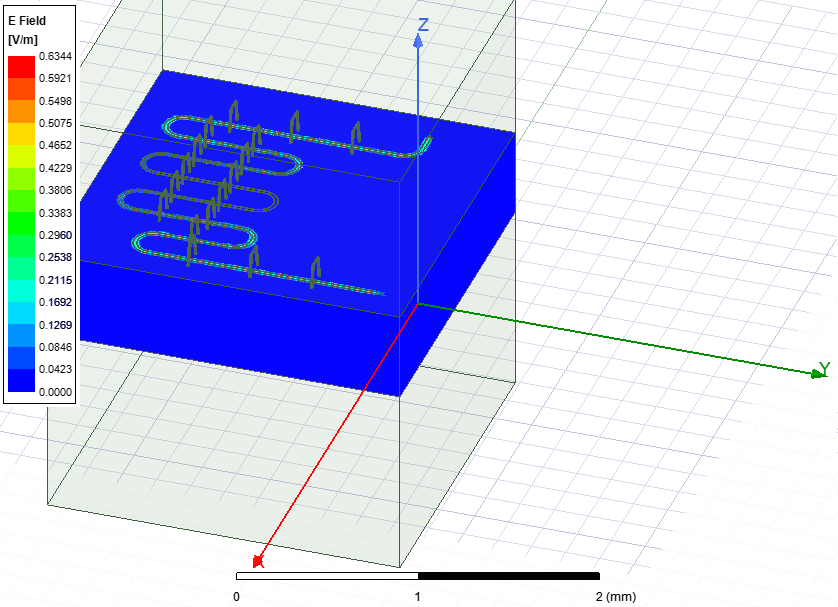

WindowsPath('C:/Users/figenyilmaz/GitLab/qiskit-metal/2FX_with_Tmon/ansys.png')

In [16]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [17]:
hfss.epr_get_frequencies()

Design "cavity1" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,6.813297,inf


In [18]:
hfss.activate_eigenmode_design("cavity2")

07:23PM 28s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
07:23PM 28s WARNING [activate_ansys_design]: The design_name=cavity2 was not in active project.  Designs in active project are: 
['FluxoniumEPR_hfss', 'Design_q3d', 'cavity1'].  A new design will be added to the project.  
INFO 07:23PM [connect_design]: 	Opened active design
	Design:    cavity2 [Solution type: Eigenmode]
WARNING 07:23PM [connect_setup]: 	No design setup detected.
WARNING 07:23PM [connect_setup]: 	Creating eigenmode default setup.
INFO 07:23PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [19]:
hfss.render_design(['cavity2'], [('cavity2', 'end'), ('cavity2', 'start')])

In [20]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10.0 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 07:23PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


07:27PM 35s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


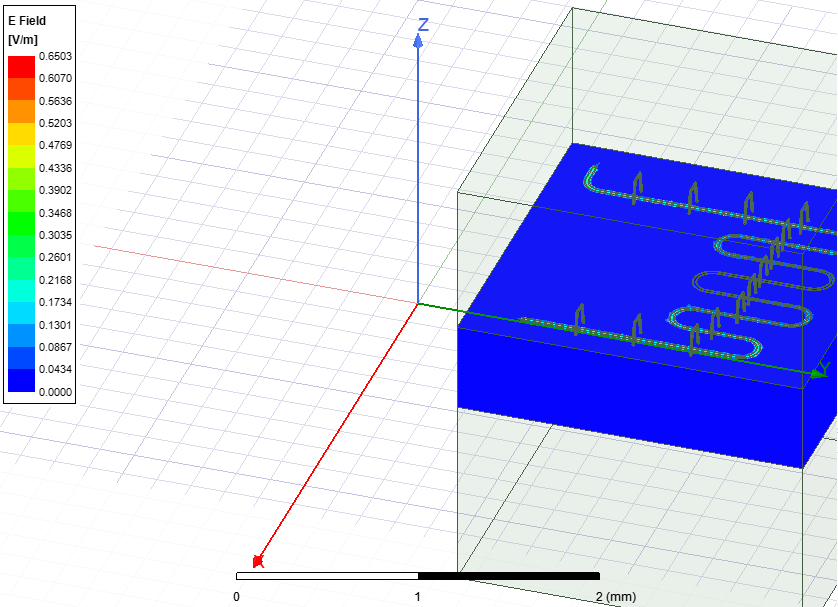

WindowsPath('C:/Users/figenyilmaz/GitLab/qiskit-metal/2FX_with_Tmon/ansys.png')

In [21]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [22]:
hfss.epr_get_frequencies()

Design "cavity2" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,7.229772,inf


In [23]:
hfss.activate_eigenmode_design("cavity4")

07:27PM 43s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
07:27PM 43s WARNING [activate_ansys_design]: The design_name=cavity4 was not in active project.  Designs in active project are: 
['FluxoniumEPR_hfss', 'Design_q3d', 'cavity1', 'cavity2'].  A new design will be added to the project.  
INFO 07:27PM [connect_design]: 	Opened active design
	Design:    cavity4 [Solution type: Eigenmode]
WARNING 07:27PM [connect_setup]: 	No design setup detected.
WARNING 07:27PM [connect_setup]: 	Creating eigenmode default setup.
INFO 07:27PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [24]:
hfss.render_design(['cavity4'], [('cavity4', 'end'), ('cavity4', 'start')])

In [25]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10.0 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 07:28PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


07:31PM 10s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


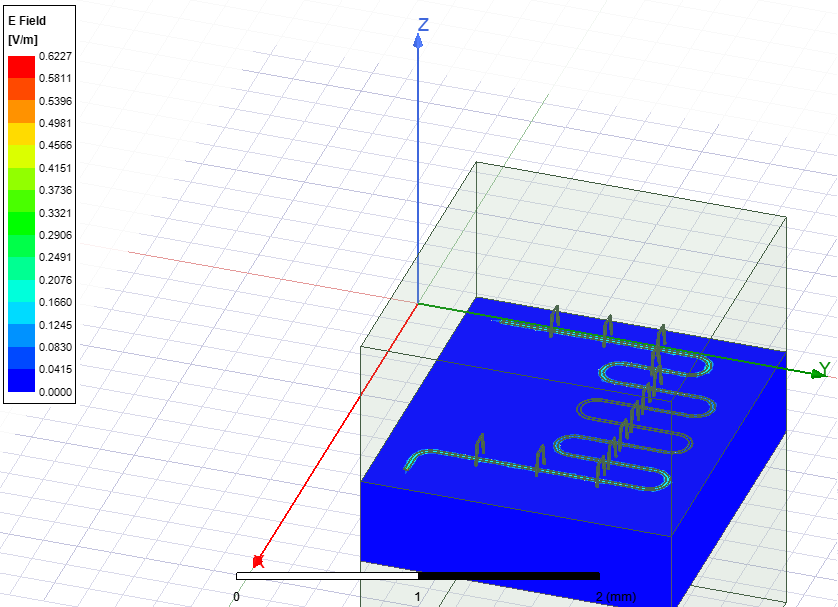

WindowsPath('C:/Users/figenyilmaz/GitLab/qiskit-metal/2FX_with_Tmon/ansys.png')

In [26]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [27]:
hfss.epr_get_frequencies()

Design "cavity4" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,7.606499,inf


In [28]:
hfss.activate_eigenmode_design("cavity5")

07:31PM 17s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
07:31PM 17s WARNING [activate_ansys_design]: The design_name=cavity5 was not in active project.  Designs in active project are: 
['FluxoniumEPR_hfss', 'Design_q3d', 'cavity1', 'cavity4', 'cavity2'].  A new design will be added to the project.  
INFO 07:31PM [connect_design]: 	Opened active design
	Design:    cavity5 [Solution type: Eigenmode]
WARNING 07:31PM [connect_setup]: 	No design setup detected.
WARNING 07:31PM [connect_setup]: 	Creating eigenmode default setup.
INFO 07:31PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [29]:
hfss.render_design(['cavity5'], [('cavity5', 'end'), ('cavity5', 'start')])

In [30]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10.0 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 07:31PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


07:33PM 31s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


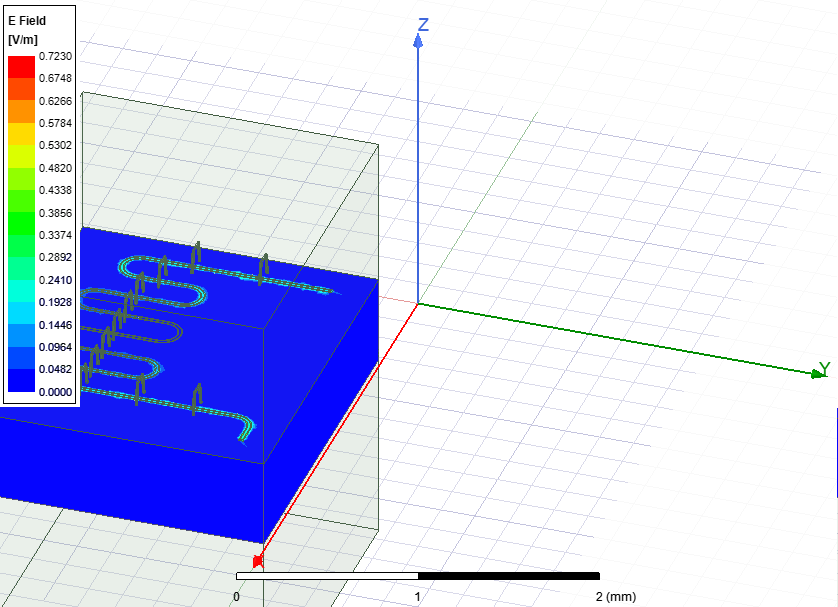

WindowsPath('C:/Users/figenyilmaz/GitLab/qiskit-metal/2FX_with_Tmon/ansys.png')

In [31]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [32]:
hfss.epr_get_frequencies()

Design "cavity5" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,8.0992,inf


In [33]:
QAnsysRenderer.get_template_options(design)

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.2,
 'y_buffer_width_mm': 0.2,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [34]:
QAnsysRenderer.default_setup

{'drivenmodal': {'name': 'Setup',
  'freq_ghz': '5.0',
  'max_delta_s': '0.1',
  'max_passes': '10',
  'min_passes': '1',
  'min_converged': '1',
  'pct_refinement': '30',
  'basis_order': '1'},
 'eigenmode': {'name': 'Setup',
  'min_freq_ghz': '1',
  'n_modes': '1',
  'max_delta_f': '0.5',
  'max_passes': '10',
  'min_passes': '1',
  'min_converged': '1',
  'pct_refinement': '30',
  'basis_order': '-1'},
 'q3d': {'name': 'Setup',
  'freq_ghz': '5.0',
  'save_fields': 'False',
  'enabled': 'True',
  'max_passes': '15',
  'min_passes': '2',
  'min_converged_passes': '2',
  'percent_error': '0.5',
  'percent_refinement': '30',
  'auto_increase_solution_order': 'True',
  'solution_order': 'High',
  'solver_type': 'Iterative'},
 'port_inductor_gap': '10um'}

In [191]:
hfss.clean_active_design()

In [148]:
hfss.activate_eigenmode_design("Q1_Res1")

11:22PM 08s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
11:22PM 08s WARNING [activate_ansys_design]: The design_name=Q1_Res1 was not in active project.  Designs in active project are: 
['cavity5', 'cavity2'].  A new design will be added to the project.  
INFO 11:22PM [connect_design]: 	Opened active design
	Design:    Q1_Res1 [Solution type: Eigenmode]
WARNING 11:22PM [connect_setup]: 	No design setup detected.
WARNING 11:22PM [connect_setup]: 	Creating eigenmode default setup.
INFO 11:22PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [149]:
hfss.options['x_buffer_width_mm'] = 0.9
hfss.options['y_buffer_width_mm'] = 0.9
hfss.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.9,
 'y_buffer_width_mm': 0.9,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [150]:
 hfss.render_design(['Q1', 'cavity1', 'otg1s'],[('cavity1', 'end')])

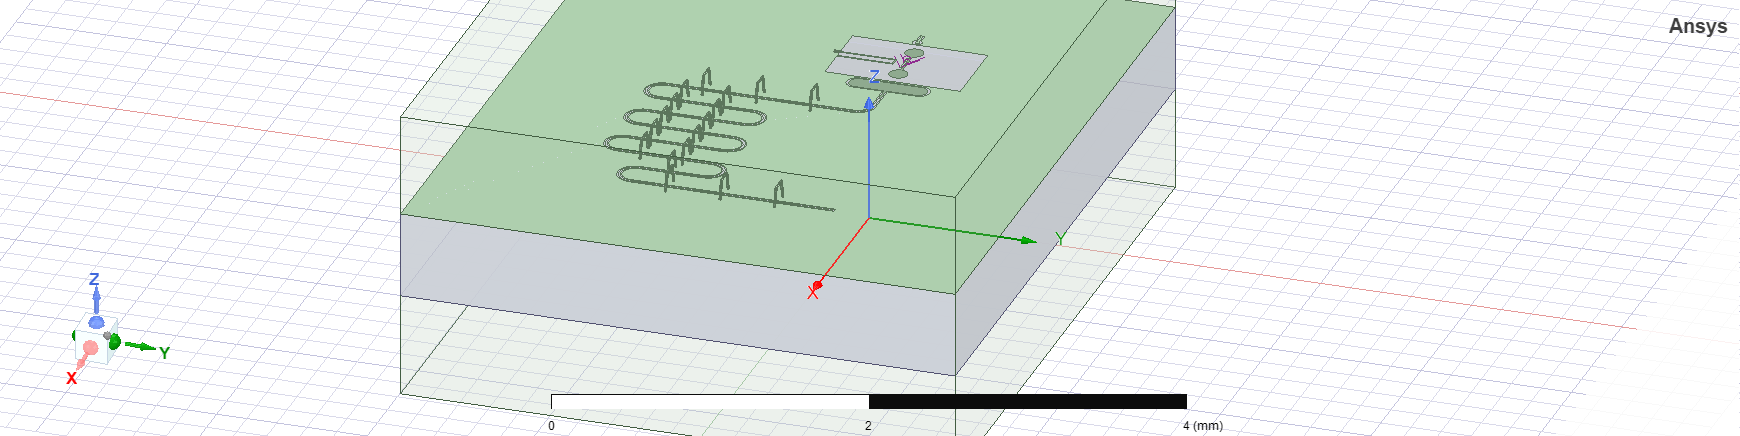

WindowsPath('C:/Users/siywa/Desktop/Siyu_design/tunable coupler/design_july/ansys.png')

In [151]:
hfss.save_screenshot()

In [152]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '34.38 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 11:22PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 2
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


11:32PM 38s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


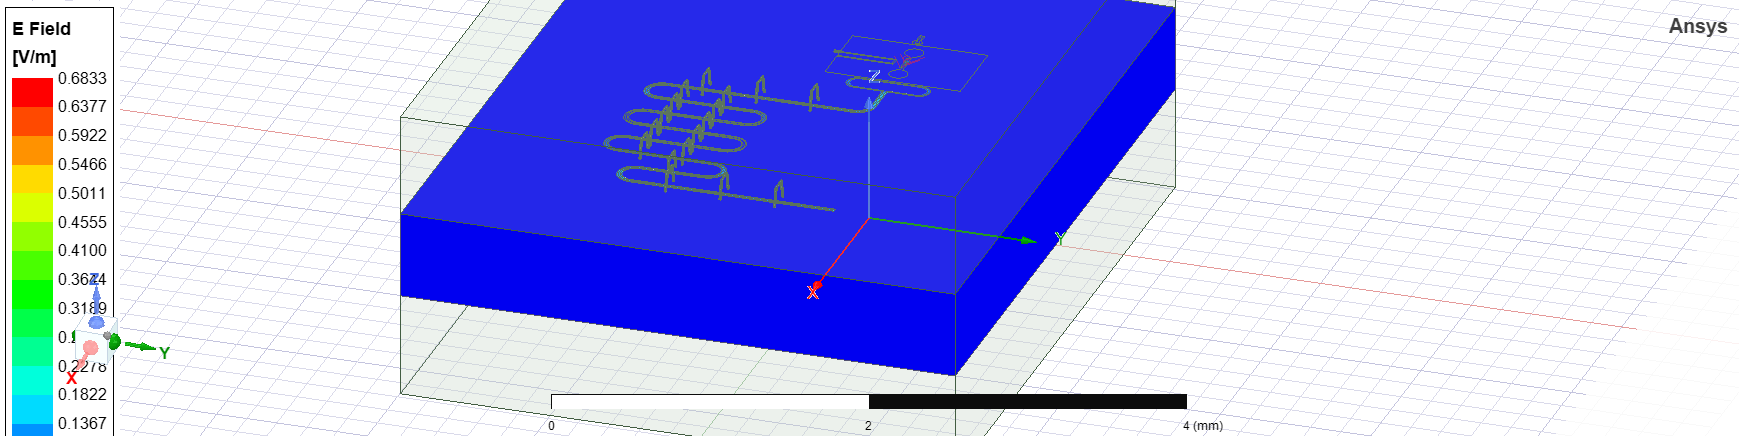

WindowsPath('C:/Users/siywa/Desktop/Siyu_design/tunable coupler/design_july/ansys.png')

In [153]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [154]:
hfss.plot_ansys_delete(['Mag_E1'])

11:32PM 52s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [155]:
hfss.set_mode(2, "Setup")

INFO 11:33PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


11:33PM 07s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


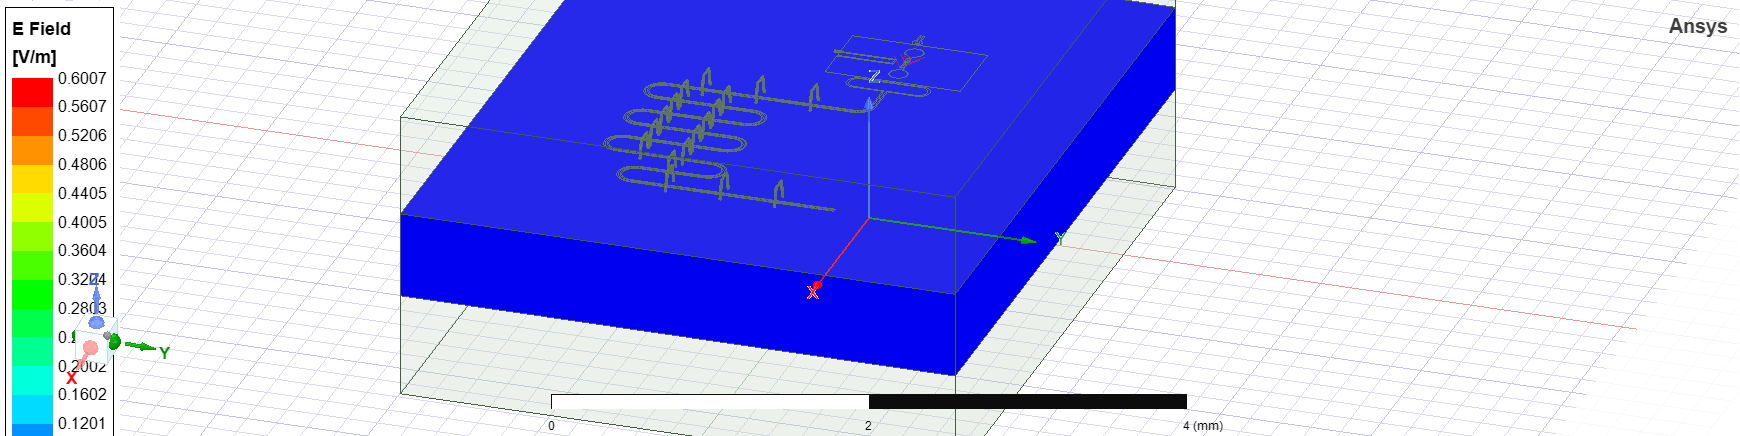

WindowsPath('C:/Users/siywa/Desktop/Siyu_design/tunable coupler/design_july/ansys.png')

In [156]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [157]:
hfss.plot_ansys_delete(['Mag_E1'])

11:33PM 16s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [158]:
hfss.epr_get_frequencies()

Design "Q1_Res1" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        6.113803             inf
          1        6.392396             inf

In [159]:
hfss.activate_eigenmode_design("Q2_Res2")

11:38PM 19s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
11:38PM 19s WARNING [activate_ansys_design]: The design_name=Q2_Res2 was not in active project.  Designs in active project are: 
['cavity5', 'cavity2', 'Q1_Res1'].  A new design will be added to the project.  
INFO 11:38PM [connect_design]: 	Opened active design
	Design:    Q2_Res2 [Solution type: Eigenmode]
WARNING 11:38PM [connect_setup]: 	No design setup detected.
WARNING 11:38PM [connect_setup]: 	Creating eigenmode default setup.
INFO 11:38PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [160]:
hfss.options['x_buffer_width_mm'] = 0.9
hfss.options['y_buffer_width_mm'] = 0.9
hfss.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.9,
 'y_buffer_width_mm': 0.9,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [161]:
hfss.render_design(['Q2', 'cavity2', 'otg2s'],[('cavity2', 'end')])

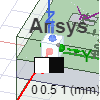

WindowsPath('C:/Users/siywa/Desktop/Siyu_design/tunable coupler/design_july/ansys.png')

In [162]:
hfss.save_screenshot()

In [163]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '34.38 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 11:38PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 2
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


01:24AM 28s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


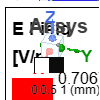

WindowsPath('C:/Users/siywa/Desktop/Siyu_design/tunable coupler/design_july/ansys.png')

In [164]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [165]:
hfss.plot_ansys_delete(['Mag_E1'])

01:24AM 34s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [166]:
hfss.set_mode(2, "Setup")

INFO 01:24AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


01:24AM 37s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


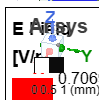

WindowsPath('C:/Users/siywa/Desktop/Siyu_design/tunable coupler/design_july/ansys.png')

In [167]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [168]:
hfss.plot_ansys_delete(['Mag_E1'])

01:24AM 43s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [169]:
hfss.epr_get_frequencies()

Design "Q2_Res2" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        6.328555             inf
          1        6.474842             inf

In [196]:
hfss.activate_eigenmode_design("Q4_Res4")

02:27AM 32s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
02:27AM 32s WARNING [activate_ansys_design]: The design_name=Q4_Res4 was not in active project.  Designs in active project are: 
[].  A new design will be added to the project.  
INFO 02:27AM [connect_design]: 	Opened active design
	Design:    Q4_Res4 [Solution type: Eigenmode]
WARNING 02:27AM [connect_setup]: 	No design setup detected.
WARNING 02:27AM [connect_setup]: 	Creating eigenmode default setup.
INFO 02:27AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [197]:
hfss.options['x_buffer_width_mm'] = 0.9
hfss.options['y_buffer_width_mm'] = 0.9
hfss.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.9,
 'y_buffer_width_mm': 0.9,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [198]:
hfss.render_design(['Q4', 'cavity4', 'otg4s'],[('cavity4', 'end')])

In [199]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '34.38 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()


Number of eigenmodes to find             = 2
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1



INFO 02:27AM [analyze]: Analyzing setup Setup


This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


03:28AM 46s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


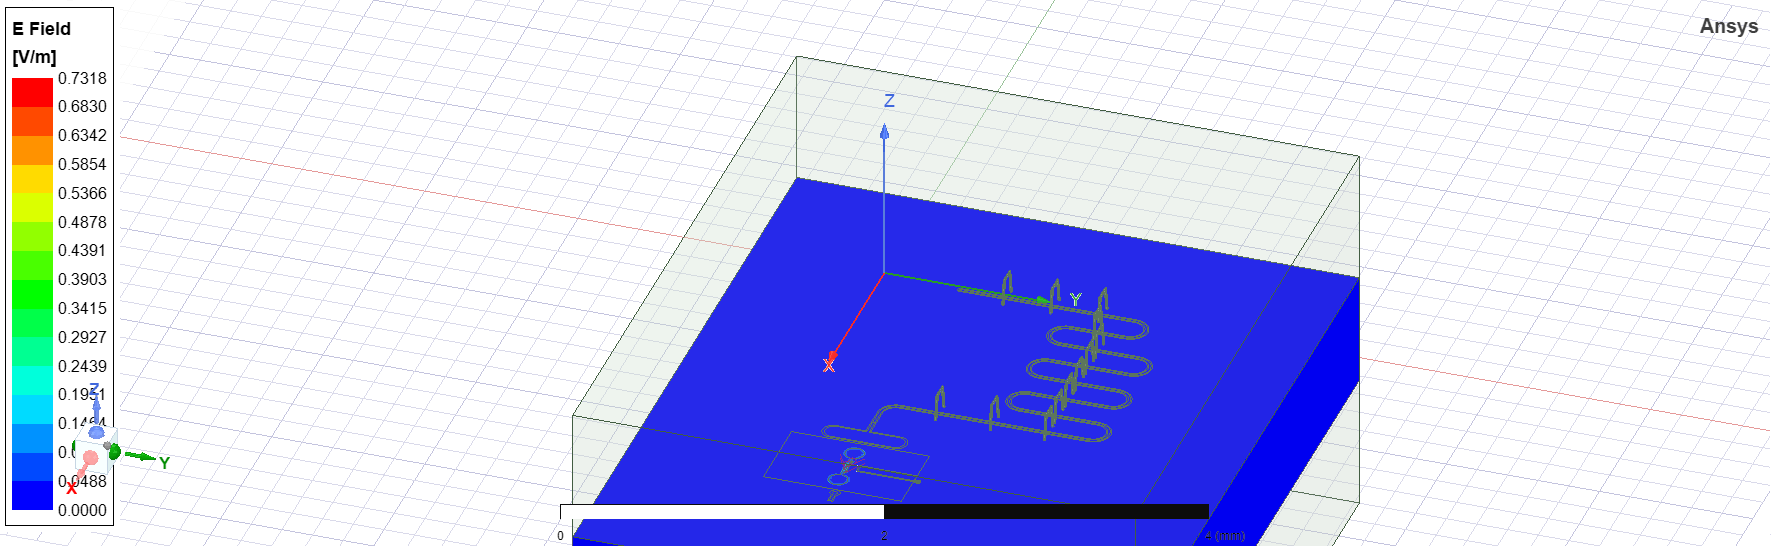

WindowsPath('C:/Users/siywa/Desktop/Siyu_design/tunable coupler/design_july/ansys.png')

In [200]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [201]:
hfss.plot_ansys_delete(['Mag_E1'])

03:28AM 55s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [202]:
hfss.set_mode(2, "Setup")

INFO 03:29AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


03:29AM 03s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


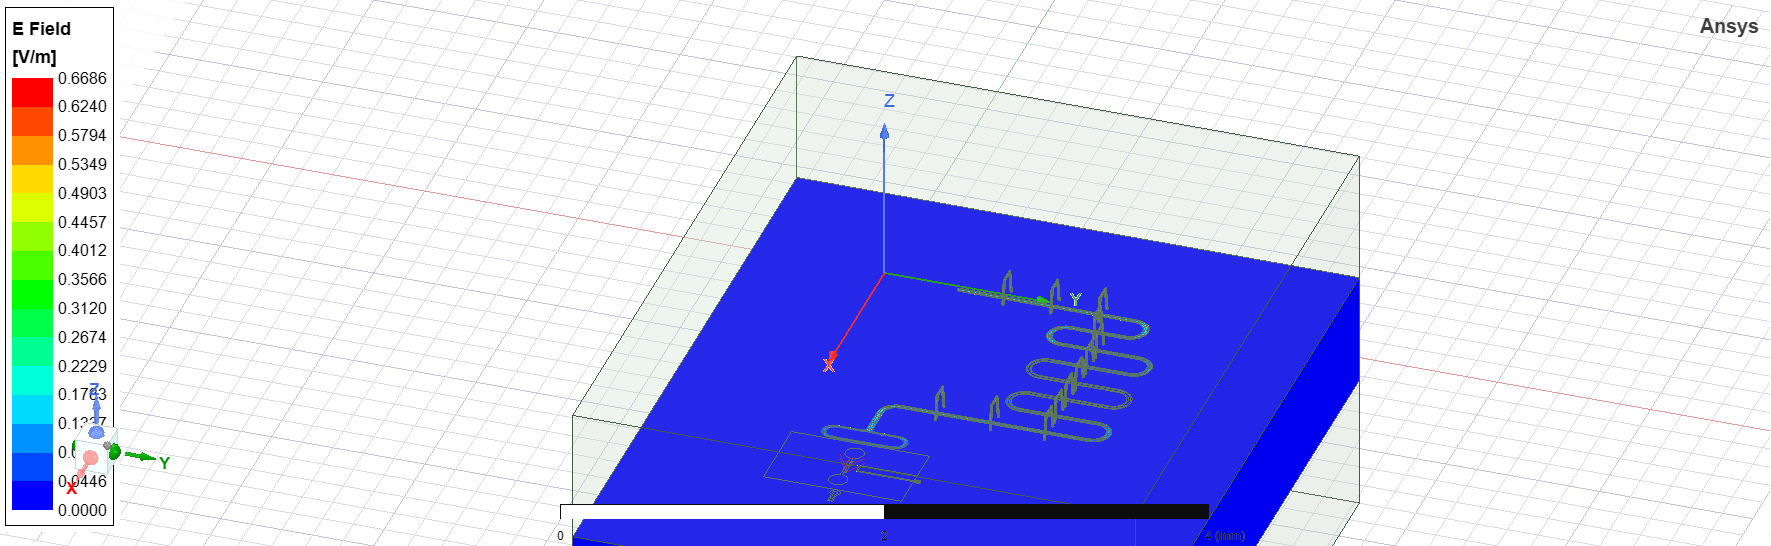

WindowsPath('C:/Users/siywa/Desktop/Siyu_design/tunable coupler/design_july/ansys.png')

In [203]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [204]:
hfss.plot_ansys_delete(['Mag_E1'])

03:29AM 19s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [205]:
hfss.epr_get_frequencies()

Design "Q4_Res4" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        6.321107             inf
          1        6.765917             inf

In [180]:
hfss.activate_eigenmode_design("Q5_Res5")

02:05AM 37s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
02:05AM 37s WARNING [activate_ansys_design]: The design_name=Q5_Res5 was not in active project.  Designs in active project are: 
['cavity5', 'cavity2', 'Q1_Res1', 'Q2_Res2', 'Q4_Res4'].  A new design will be added to the project.  
INFO 02:05AM [connect_design]: 	Opened active design
	Design:    Q5_Res5 [Solution type: Eigenmode]
WARNING 02:05AM [connect_setup]: 	No design setup detected.
WARNING 02:05AM [connect_setup]: 	Creating eigenmode default setup.
INFO 02:05AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [181]:
hfss.options['x_buffer_width_mm'] = 0.9
hfss.options['y_buffer_width_mm'] = 0.9
hfss.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.9,
 'y_buffer_width_mm': 0.9,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [182]:
hfss.render_design(['Q5', 'cavity5', 'otg5s'],[('cavity5', 'end')])

In [183]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '34.38 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 02:06AM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 2
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


02:24AM 05s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


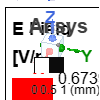

WindowsPath('C:/Users/siywa/Desktop/Siyu_design/tunable coupler/design_july/ansys.png')

In [186]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [187]:
hfss.plot_ansys_delete(['Mag_E1'])

02:24AM 09s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [188]:
hfss.set_mode(2, "Setup")

INFO 02:24AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


02:24AM 12s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


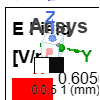

WindowsPath('C:/Users/siywa/Desktop/Siyu_design/tunable coupler/design_july/ansys.png')

In [189]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [190]:
hfss.epr_get_frequencies()

Design "Q5_Res5" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        6.353110             inf
          1        7.087337             inf